# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: Annie Stewart and Lauren Servia

**ID**:

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\19193\Desktop\BEE4750\hw\hw5-annielauren`
   Installed LERC_jll ───────────── v4.0.0+0
   Installed GR_jll ─────────────── v0.73.8+0
   Installed JpegTurbo_jll ──────── v3.0.4+0
   Installed MutableArithmetics ─── v1.5.2
   Installed LoggingExtras ──────── v1.1.0
   Installed OffsetArrays ───────── v1.14.1
   Installed Cairo_jll ──────────── v1.18.2+1
   Installed PlotUtils ──────────── v1.4.3
   Installed StaticArrays ───────── v1.9.8
   Installed NetworkLayout ──────── v0.4.7
   Installed HTTP ───────────────── v1.10.10
   Installed DataFrames ─────────── v1.7.0
   Installed Libgpg_error_jll ───── v1.50.0+0
   Installed HiGHS_jll ──────────── v1.8.1+0
   Installed FFMPEG ─────────────── v0.4.2
   Installed Bzip2_jll ──────────── v1.0.8+2
   Installed SentinelArrays ─────── v1.4.7
   Installed CodecBzip2 ─────────── v0.8.4
   Installed XZ_jll ─────────────── v5.6.3+0
   Installed LZO_jll ────────────── v2.10.2+1
   Installed PlotThemes ─────────── v3.

In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?


### General Problem Formulation 
#### Decision Variables 
- $W_ij$ = waste transported from city i to disposal j (Mg/day)
- $R_kj$ = residual waste transported from disposal k to disposal j (Mg/day)
- $Y_j$ = Operational status (on/off) of disposal j (not included in this problem)

#### Objective 

Cost = Transportation Cost + Disposal Cost
- $a_ij$ = cost of transporting waste from source i to disposal j ($/Mg-km)
- $l_ij$ = distance between source i and disposal j (km)
- Transportation Costs = $\sum$ $a_ij$ * $l_if$ * $W_ij$
- $c_j$ = fixed costs of operating disposal j ($/day)
- $b_j$ = variable costs of disposing waste at disposal j (dollars/Mg)
- Disposal Costs = $\sum$ ($c_j$ + $b_j$ $\sum$ $W_ij$)

#### Constraints 
1) Need to dispose of all waste from each source i: 
$\sum$ $W_ij$ = $S_i$

2) Capacity limit at each disposal site j: 
$\sum$ $W_ij$ + $\sum$ $R_kj$ $<=$ $K_j$

3) $W_ij$ $>=$ 0

#### Function
- min $\sum$ $\sum$ $a_ij$ * $l_ij$ * $W_ij$ + $\sum$ ($c_j$ * $Y_j$ + $\sum$ $b_j$ * $W_ij$)

### Values in this problem
- Number of cities, num_cities = 3 [cities]
   - sw_production_c1 = 100 [Mg/day]
   - sw_production_c2 = 90 [Mg/day]
   - sw_production_c3 = 120 [Mg/day]
- Number of disposal alternatives = 3 [disposal alternatives]
   1) LF = landfill
   2) MRF = materials recyclying facility
   3) WTE = waste-to-energy facility
- transport_cost = 1.5 [$/(Mg*km)]
- i = city i
- j = waste facility j
- allocation_waste[i_1:i_3, j_1:j_3] = waste load allocations for city 1, city 2, city 3, and for facilities LF, MRF, and WTE.


##### LF Associated Data
- c_LF = 200 [Mg]
- fc_LF = 2000 [$/day]
- tip_cost_LF = 50 [$/Mg]


##### MRF Associated Data
- c_MRF = 350 [Mg]
- fc_MRF = 1500 [$/day]
- tip_cost_MRF = 7 [$/Mg]
- recyc_cost_MRF = 40 [$/Mg]
- recyc_rate_MRF = 0.4 [dimensionless]
- f_ash_nonrecyc_MRF = 0.16 [dimensionless]
- f_ash_nonrecyc_MRF = 0.14 [dimensionless]


##### WTE Associated Data
- c_WTE = 210 [Mg]
- fixed cost = 2500 [$/day]
- tip_cost_WTE = 60 [$/Mg]

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+01, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [9e+01, 4e+02]
Presolving model
4 rows, 6 cols, 9 nonzeros  0s
1 rows, 2 cols, 2 nonzeros  0s
Presolve : Reductions: rows 1(-5); columns 2(-7); elements 2(-16)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          1     2.2216428571e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 1
Objective value     :  2.2216428571e+04
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Total cost for the waste loads allocation model = 22216.428571428572dollars
City 1 -> Facility 1 = 80.0 [Mg]
City 1 -> Facility 2 = 20.0 [Mg]
City 1 -> Facility 3 = 0.0 [Mg]
City 2 -> Facility 1 = 0.0 [Mg]


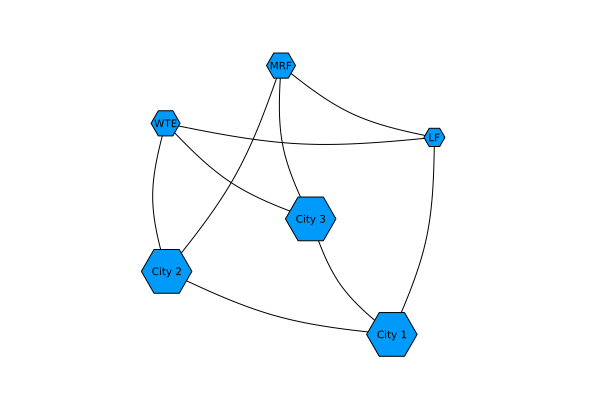

In [ ]:

# Initialize GLPK model for waste loads allocation
waste_model = Model(HiGHS.Optimizer)

# Initialize variables (decision variables for waste loads)
@variable(waste_model, allocation_load[1:3, 1:3] >= 0) # non-negativity constraint

# Distances between cities and waste facilities
distances = DataFrame(
    LF = [5, 15, 13],     # LF distances for City 1, 2, 3
    MRF = [30, 25, 45],   # MRF distances for City 1, 2, 3
    WTE = [15, 10, 20]    # WTE distances for City 1, 2, 3
)

# Constants (fixed costs, capacities, etc.)
transport_cost = 1.5  # [$/(Mg*km)]

# LF Associated Data
c_LF = 200            # [Mg]
fc_LF = 2000          # [$/day]
tip_cost_LF = 50      # [$/Mg]

# MRF Associated Data
c_MRF = 350           # [Mg]
fc_MRF = 1500         # [$/day]
tip_cost_MRF = 7      # [$/Mg]
recyc_cost_MRF = 40   # [$/Mg]
recyc_rate_MRF = 0.4  # [dimensionless]
f_ash_nonrecyc_MRF = 0.16  # [dimensionless]

# WTE Associated Data
c_WTE = 210           # [Mg]
fc_WTE = 2500         # [$/day]
tip_cost_WTE = 60     # [$/Mg]

# Objective function: Minimize the total cost
@objective(waste_model, Min,
    sum(allocation_load[i, j] * transport_cost * distances[i, j] for i in 1:3, j in 1:3) + 
    sum(allocation_load[1:3, 1] * fc_LF / c_LF) + 
    sum(allocation_load[1:3, 2] * fc_MRF / c_MRF) +
    sum(allocation_load[1:3, 3] * fc_WTE / c_WTE) + 
    sum(allocation_load[1:3, 1] * tip_cost_LF) + 
    sum(allocation_load[1:3, 2] * (tip_cost_MRF + recyc_cost_MRF * recyc_rate_MRF)) + 
    sum(allocation_load[1:3, 3] * tip_cost_WTE)
)

# Constraints
# Total waste produced by each city
@constraint(waste_model, sum(allocation_load[1, 1:3]) == 100)  # City 1 produces 100 Mg/day
@constraint(waste_model, sum(allocation_load[2, 1:3]) == 90)   # City 2 produces 90 Mg/day
@constraint(waste_model, sum(allocation_load[3, 1:3]) == 120)  # City 3 produces 120 Mg/day

# Maximum capacity for each facility
@constraint(waste_model, sum(allocation_load[1:3, 1]) <= c_LF)  # LF capacity
@constraint(waste_model, sum(allocation_load[1:3, 2]) <= c_MRF) # MRF capacity
@constraint(waste_model, sum(allocation_load[1:3, 3]) <= c_WTE) # WTE capacity

# Optimize the model
optimize!(waste_model)

# Display results
println("Total cost for the waste loads allocation model = ", objective_value(waste_model), "dollars")

# Display the allocation of waste between cities and facilities
for i in 1:3
    for j in 1:3
        println("City ", i, " -> Facility ", j, " = ", value(allocation_load[i, j]), " [Mg]")
    end
end

# Plot the waste allocation using a graph
allocated_waste = [value(allocation_load[i, j]) for i in 1:3, j in 1:3]

# Matrix for empty connections
empty_matrix = [
    0 1 1 1 0 0;
    1 0 0 0 1 1;
    1 0 0 0 1 1;
    1 0 0 0 1 1;
    0 1 1 1 0 0;
    0 1 1 1 0 0
]

# Names for cities and facilities
names = ["City 1", "City 2", "City 3", "LF", "MRF", "WTE"]

# Visualize the flows
graphplot(empty_matrix, names=names, line_width=allocated_waste / (maximum(allocated_waste)*10), legend=false)



The output of the model gives: 

|     **City**      | **Landfill (Mg)** | **MRF (Mg)** | **WTE (Mg)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |        80         |      20      |       0      |
|         2         |        90         |       0      |       0      |
|         3         |       120         |       0      |       0      |

Total cost for the waste loads allocation model = 22216.428571428572 dollars

As shown in the table, all three cities use the landfill. This makes sense because it is usually the least expensive option due to lower tipping costs. Only City 1 uses the MRF. WTE is not used by any city, which makes sense because of the high tipping costs ($60/Mg) make it make less economic sense, especially since recycling (MRF) is much cheaper (hence City 1 using MRF instead of WTE).



## References

List any external references consulted, including classmates.